Based on:

P. Donizy, M. Krzyzinski et al. Machine learning models demonstrate that clinicopathologic variables are comparable to gene expression prognostic signature in predicting survival in uveal melanoma. 

European Journal of Cancer, 2022.

paper: https://doi.org/10.1016/j.ejca.2022.07.031

code: https://doi.org/10.24433/CO.0762447.v1

In [15]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv

import src

In [2]:
df_train_raw = pd.read_csv('data/uvealmelanoma_ejc2022_train.csv')
df_valid_raw = pd.read_csv('data/uvealmelanoma_ejc2022_valid.csv')

In [3]:
categorical_variables = ["sex",
                         "stage",
                         "tumor.location",
                         "histologic.subtype",               
                         "scleral.infiltration",
                         "invasion.optic.nerve.head",        
                         "extraocular.growth",
                         "necrosis",                         
                         "lymphovascular.invasion",
                         "pigmentation.clinical",            
                         "tumor.shape",
                         "retinal.detachment",               
                         "glaucoma",
                         "clinical.localization",
                         "TIL.pattern",    
                         "TIL.density",
                         "TIM.pattern",    
                         "TIM.density",
                         "pigment.quantity",            
                         "pigment.quality",
                         "nucleoli.size",
                         "hemorrhage",                       
                         "BAP1.mutation",
                         "ciliary.body.infiltration"]

In [141]:
df_train = df_train_raw.dropna().reset_index(drop=True)
X_train = df_train.drop(["os.status", "os", "pfs.status", "pfs"] + categorical_variables, axis=1)
y_train = Surv().from_dataframe("os.status", "pfs", df_train)

In [142]:
df_valid = df_valid_raw.dropna().reset_index(drop=True).loc[:, pd.Series(np.intersect1d(df_valid_raw.columns.values, df_train_raw.columns.values))]
X_valid = df_valid.drop(["os.status", "os", "pfs.status", "pfs"] + np.intersect1d(df_valid_raw.columns.values, categorical_variables).tolist(), axis=1)
X_valid = X_valid.loc[:, X_train.columns]
y_valid = Surv().from_dataframe("os.status", "pfs", df_valid)

In [146]:
model = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=456)

In [147]:
model.fit(X_train.values, y_train)

,loss,'coxph'
,learning_rate,0.05
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,random_state,456


In [148]:
print(f'Train score: {model.score(X_train.values, y_train).item():.03f} | Valid score: {model.score(X_valid.values, y_valid).item():.03f}')

Train score: 0.921 | Valid score: 0.740


In [13]:
np.random.seed(456)
explanations_order1 = src.survshapiq(
    model, 
    X_train.values, 
    [X_valid.iloc[[i]] for i in range(0, X_valid.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="SV",
    approximator="auto",
    max_order=1
)

100%|██████████| 77/77 [33:22<00:00, 26.01s/it]


In [16]:
filename = f'results/uvealmelanoma_explanations_order1.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order1, f)

In [19]:
timepoints = src.get_evenly_spaced_integers(model.unique_times_, 41)

In [62]:
df_plot1 = pd.concat([explanations_order1[i].assign(time=timepoints, id=i) for i in range(X_valid.shape[0])])
df_plot1 = pd.melt(df_plot1, id_vars=['time', 'id'], var_name="feature")

In [63]:
df_plot1.feature = df_plot1.feature.map({'mean.nuclear.area': 'nuclear_area', 
                      'mean.nucleus.perimeter': 'nucleus_perimeter',
                      'mean.nucleus.circularity': 'nucleus_circularity',
                      'mean.nucleus.max.caliper': 'nucleus_max_caliper',
                      'mean.nucleus.min.caliper': 'nucleus_min_caliper',
                      'age': 'age',
                      'largest.basal.tumor.diameter': 'max_tumor_diameter',
                      'tumor_thickness': 'tumor_thickness',
                      'mitotic.rate': 'mitotic_rate'})

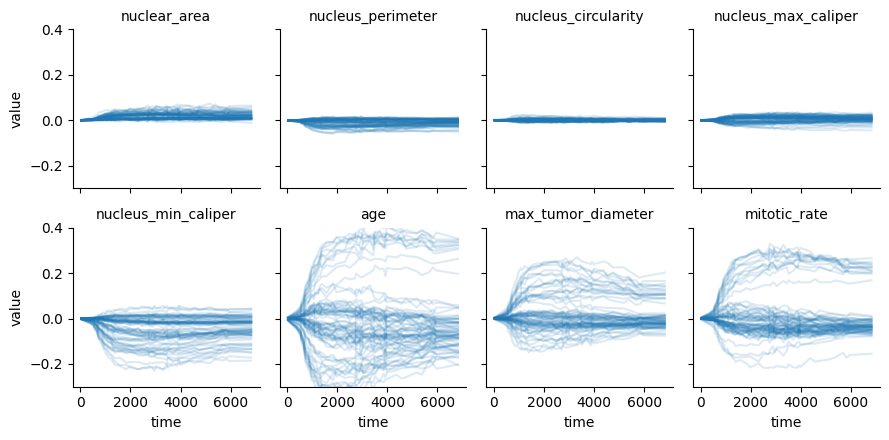

In [64]:
ax = sns.relplot(
    df_plot1, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2.25,
    aspect=1,
    col_wrap=4
)
ax.set_titles(col_template="{col_name}")
# ax.set(xscale='log')
ax.set(ylim=(-0.3, 0.4))
plt.tight_layout()
plt.savefig(f'results/uvealmelanoma_order1_global.png', bbox_inches="tight")

In [17]:
np.random.seed(456)
explanations_order2 = src.survshapiq(
    model, 
    X_train.values, 
    [X_valid.iloc[[i]] for i in range(0, X_valid.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="k-SII",
    approximator="auto",
    max_order=2
)

100%|██████████| 77/77 [32:45<00:00, 25.53s/it]


In [18]:
filename = f'results/uvealmelanoma_explanations_order2.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order2, f)

In [80]:
df_plot2 = pd.concat([explanations_order2[i].assign(time=timepoints, id=i) for i in range(X_valid.shape[0])])
df_plot2 = pd.melt(df_plot2, id_vars=['time', 'id'], var_name="feature") #, 'treatment'])

In [81]:
df_plot2.feature = df_plot2.feature.str.replace("*", "\n *")

In [66]:
df_plot2.feature = df_plot2.feature.map({'mean.nuclear.area': 'nuclear_area', 
                      'mean.nucleus.perimeter': 'nucleus_perimeter',
                      'mean.nucleus.circularity': 'nucleus_circularity',
                      'mean.nucleus.max.caliper': 'nucleus_max_caliper',
                      'mean.nucleus.min.caliper': 'nucleus_min_caliper',
                      'age': 'age',
                      'largest.basal.tumor.diameter': 'max_tumor_diameter',
                      'tumor_thickness': 'tumor_thickness',
                      'mitotic.rate': 'mitotic_rate'})

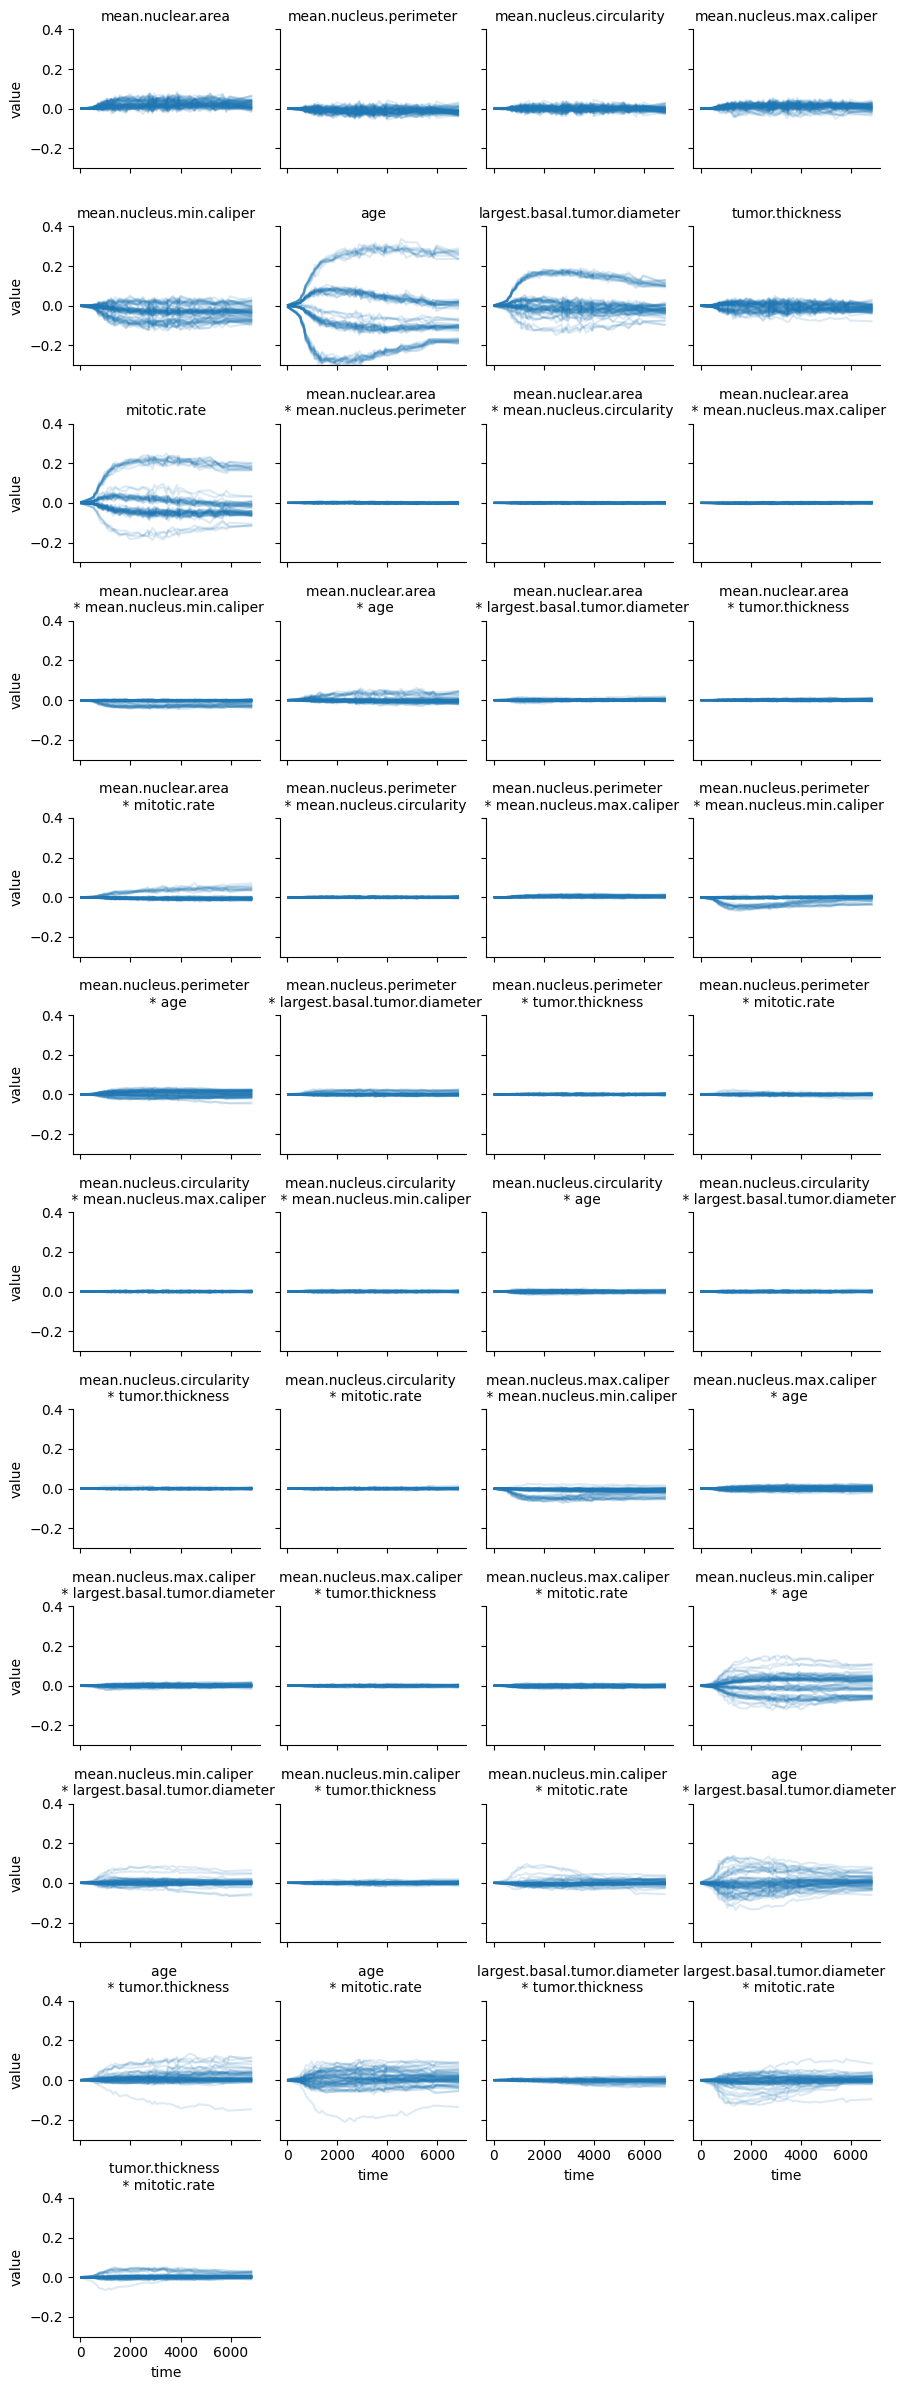

In [149]:
ax = sns.relplot(
    df_plot2, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2,
    aspect=1.125,
    col_wrap=4
)
ax.set_titles(col_template="{col_name}")
ax.set(ylim=(-0.3, 0.4))
plt.tight_layout()
plt.savefig(f'results/uvealmelanoma_order2_global.png', bbox_inches="tight")
# plt.clf()